# Baysian Two-way Fixed Effects

- 階層ベイズモデル 不均一分散
- GLMM 不均一分散
- GLM 均一分散

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [2]:
filepath = '../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)
df

island_ids  year  pseudo_year region_codes  prefecture_codes  \
0             67  1970         1970        32202                32   
1             67  1975         1975        32202                32   
2             67  1980         1980        32202                32   
3             67  1985         1985        32202                32   
4             67  1990         1990        32202                32   
...          ...   ...          ...          ...               ...   
1858         226  2000         2000        39424                39   
1859         226  2005         2005        39424                39   
1860         226  2010         2010        39424                39   
1861         226  2015         2015        39424                39   
1862         226  2020         2020        39424                39   

      population  treatment_group  treatment_group_mainland  bridge_year  \
0            NaN                1                         1         1999   
1            NaN                1                         1         1999   
2            NaN                1                         1         1999   
3            NaN                1                         1         1999   
4            NaN                1                         1         1999   
...          ...              ...                       ...          ...   
1858       398.0                1                         1         1957   
1859       365.0                1                         1         1957   
1860       343.0                1                         1         1957   
1861       284.0                1                         1         1957   
1862       225.0                1                         1         1957   

      pseudo_bridge_year  ...  connect_mainland_year  \
0                   1999  ...                   1999   
1                   1999  ...                   1999   
2                   1999  ...                   1999   
3                   1999  ...                   1999   
4                   1999  ...                   1999   
...                  ...  ...                    ...   
1858                1957  ...                   1957   
1859                1957  ...                   1957   
1860                1957  ...                   1957   
1861                1957  ...                   1957   
1862                1957  ...                   1957   

      after_treatment_mainland        income  area_km2  distance_m   log_pop  \
0                            0           NaN      0.28       615.0       NaN   
1                            0           NaN      0.28       615.0       NaN   
2                            0           NaN      0.28       615.0       NaN   
3                            0  4.243674e+07      0.28       615.0       NaN   
4                            0  4.786833e+07      0.28       615.0       NaN   
...                        ...           ...       ...         ...       ...   
1858                         1  5.113370e+02      0.56       110.0  5.986452   
1859                         1  4.533435e+02      0.56       110.0  5.899897   
1860                         1  3.903833e+02      0.56       110.0  5.837730   
1861                         1  4.064721e+02      0.56       110.0  5.648974   
1862                         1  3.758701e+02      0.56       110.0  5.416100   

        pop_star  log_pop_star  time_since_treatment  is_already_treated  
0            NaN           NaN                   -29                   0  
1            NaN           NaN                   -24                   0  
2            NaN           NaN                   -19                   0  
3            NaN           NaN                   -14                   0  
4            NaN           NaN                    -9                   0  
...          ...           ...                   ...                 ...  
1858  -51.742797     -0.002503                    43                   1  
1859   88.193373  

## TWFE

$$
\log{Y^*_{it}} = \log{Y_{it}} - \bar{\log{{Y}_{i}}}
$$

$$
\begin{aligned}
\log{Y^*_{it}} &\sim \mathcal{t}(\nu, \mu_{it}, \sigma^2) \\
\mu_{it} &= \beta \cdot T_{it} \\
\beta &\sim \mathcal{N}(0, 1) \\
\nu &\sim \mathcal{Exponential}(\lambda = 1/10) \\
\sigma &\sim \mathcal{Cauchy}^+(\beta=1) \\
\end{aligned}
$$

### GLMM

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


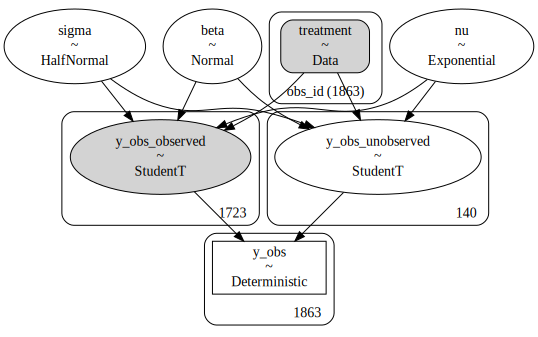

In [4]:
COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as model:
    # data
    treatment = pm.Data('treatment', df['after_treatment'], dims='obs_id')

    # priors

    # fixed effects
    beta = pm.Normal('beta', mu=0, sigma=0.3)
    nu = pm.Exponential('nu', lam=1/10)
    sigma = pm.HalfNormal('sigma', sigma=0.24) # y_std = df['log_pop_star'].std() = 0.242

    # expectation
    mu = beta * treatment

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=df['log_pop_star'])

pm.model_to_graphviz(model)

In [5]:
with model:
    trace = pm.sample(
        draws=1000,
        tune=500,
        chains=4,
        nuts_sampler='numpyro',
        random_seed=42,
    )

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [6]:
az.summary(trace, hdi_prob=.95, var_names=['beta', 'nu', 'sigma'])

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta  -0.006  0.009    -0.024      0.010      0.000    0.000    7619.0   
nu     2.849  0.226     2.420      3.292      0.004    0.003    3348.0   
sigma  0.147  0.005     0.138      0.157      0.000    0.000    3843.0   

       ess_tail  r_hat  
beta     3327.0    1.0  
nu       2509.0    1.0  
sigma    3272.0    1.0

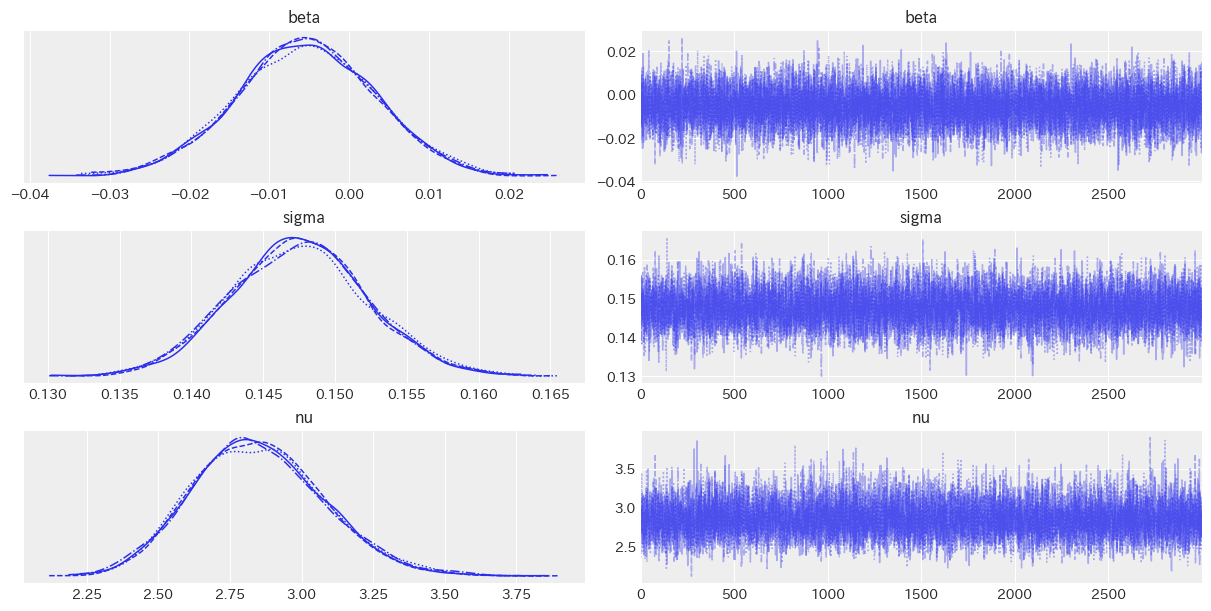

In [12]:
az.plot_trace(trace, var_names=['beta', 'sigma', 'nu']);

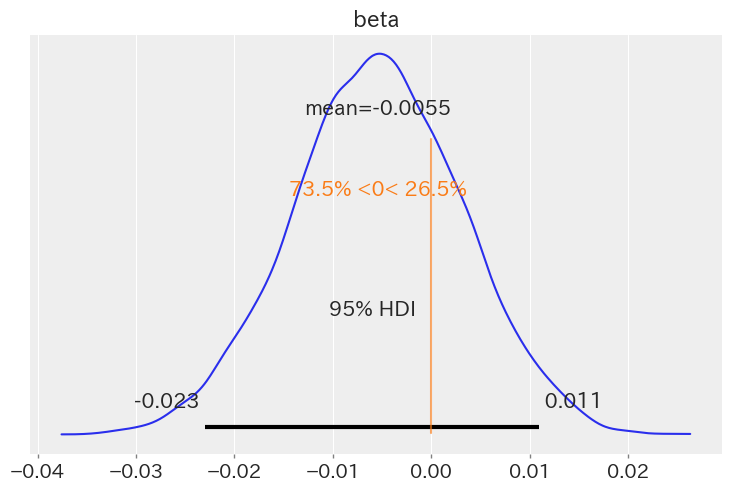

In [13]:
az.plot_posterior(trace, var_names=['beta'], ref_val=0, hdi_prob=.95);

In [14]:
with model:
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Output()

Sampling: [y_obs_observed]


Output()

In [15]:
az.waic(trace)

Computed from 12000 posterior samples and 1723 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   203.60    44.88
p_waic        3.06        -

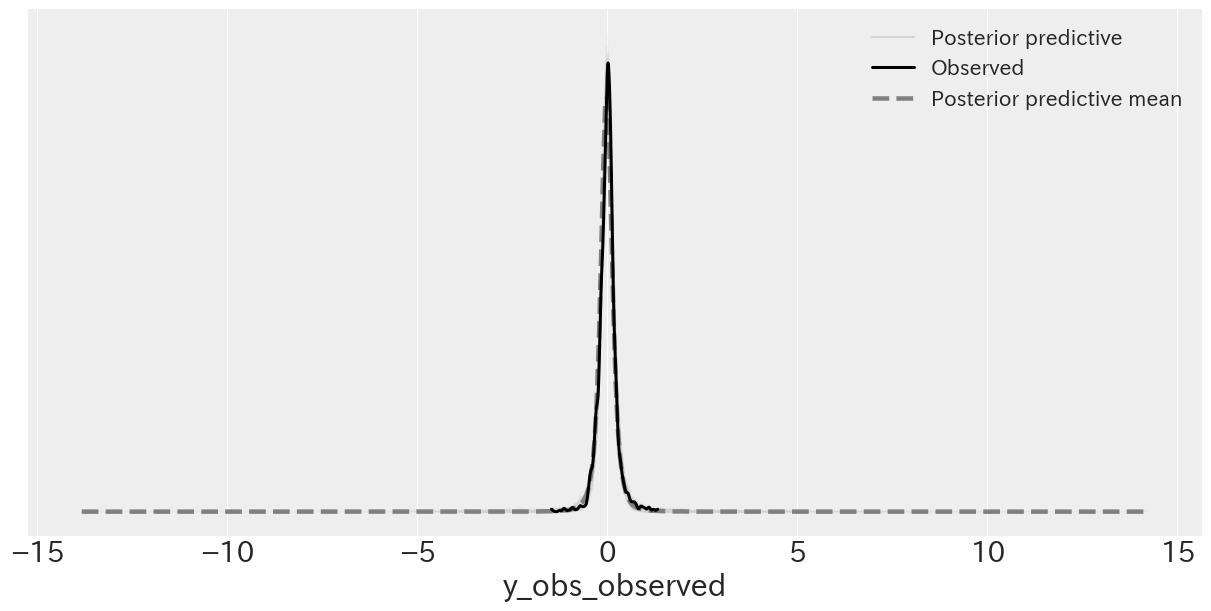

In [60]:
az.plot_ppc(
    trace,
    num_pp_samples=100,
    kind='kde',
    figsize=(12, 6),
    colors=('lightgray', 'black', 'gray')
);

## GLMM 不均一分散

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


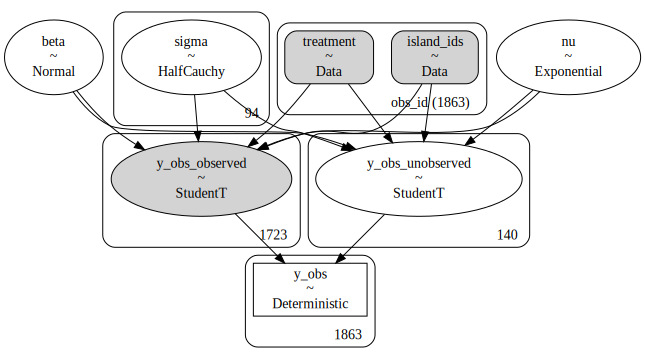

In [4]:
# 0から始まるインデックスを振り直す
island_ids, unique_island_ids = pd.factorize(df['island_ids'])
n_islands = len(unique_island_ids)

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as model_h:
    # data
    island_ids = pm.Data('island_ids', island_ids, dims='obs_id')
    treatment = pm.Data('treatment', df['after_treatment'], dims='obs_id')

    # priors
    # random effects
    sigma = pm.HalfCauchy('sigma', beta=1, shape=n_islands)

    # fixed effects
    beta = pm.Normal('beta', mu=0, sigma=1)
    nu = pm.Exponential('nu', lam=1/10)

    # expectation
    mu = beta * treatment

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma[island_ids], observed=df['log_pop_star'])

pm.model_to_graphviz(model_h)

In [5]:
with model_h:
    trace_h = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        cores=4,
        nuts_sampler='numpyro',
        random_seed=42,
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [6]:
az.summary(trace_h, var_names=['beta', 'nu', 'sigma'], hdi_prob=.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta        0.028  0.009     0.009      0.045      0.000    0.000    1503.0   
nu         10.619  3.096     6.191     16.466      0.088    0.062    1350.0   
sigma[0]    0.152  0.064     0.062      0.278      0.002    0.001    1350.0   
sigma[1]    0.324  0.054     0.230      0.430      0.001    0.001    4191.0   
sigma[2]    0.061  0.010     0.043      0.080      0.000    0.000    4234.0   
...           ...    ...       ...        ...        ...      ...       ...   
sigma[89]   0.153  0.024     0.111      0.205      0.000    0.000    4356.0   
sigma[90]   0.089  0.014     0.064      0.117      0.000    0.000    5031.0   
sigma[91]   0.354  0.086     0.210      0.528      0.001    0.001    4903.0   
sigma[92]   0.346  0.084     0.211      0.512      0.001    0.001    4718.0   
sigma[93]   0.070  0.027     0.033      0.125      0.001    0.001    1842.0   

           ess_tail  r_hat  
beta         2031.0    1.0  
nu           1523.0    1.0  
sigma[0]     1196.0    1.0  
sigma[1]     2958.0    1.0  
sigma[2]     3036.0    1.0  
...             ...    ...  
sigma[89]    3017.0    1.0  
sigma[90]    2991.0    1.0  
sigma[91]    2562.0    1.0  
sigma[92]    3169.0    1.0  
sigma[93]    1726.0    1.0  

[96 rows x 9 columns]

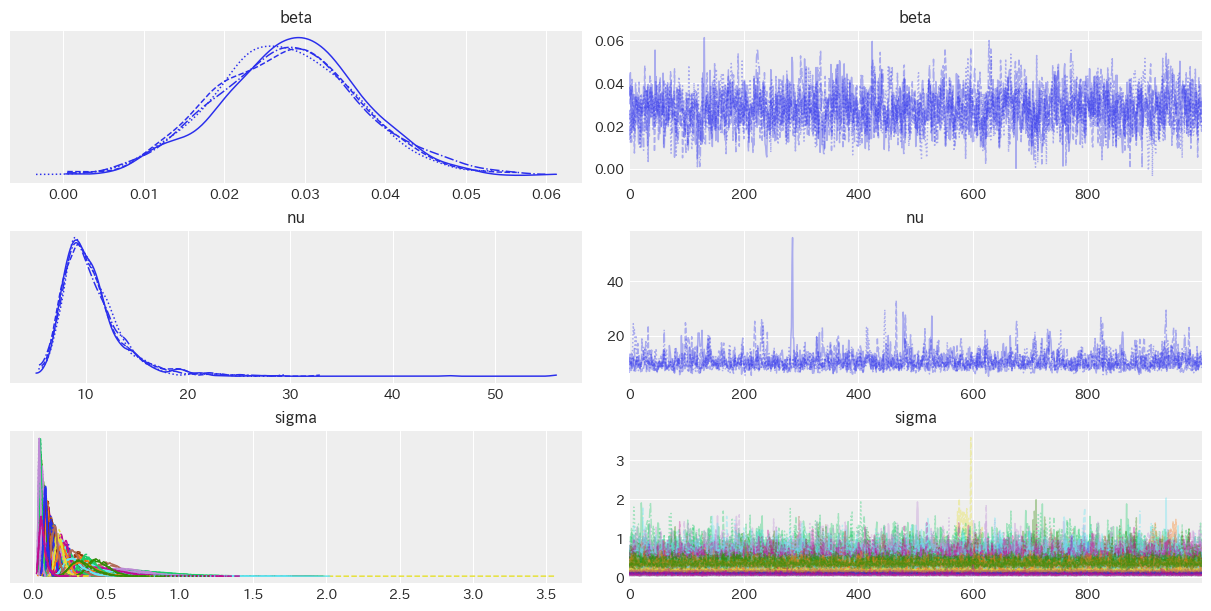

In [9]:
az.plot_trace(trace_h, var_names=['beta', 'nu', 'sigma']);

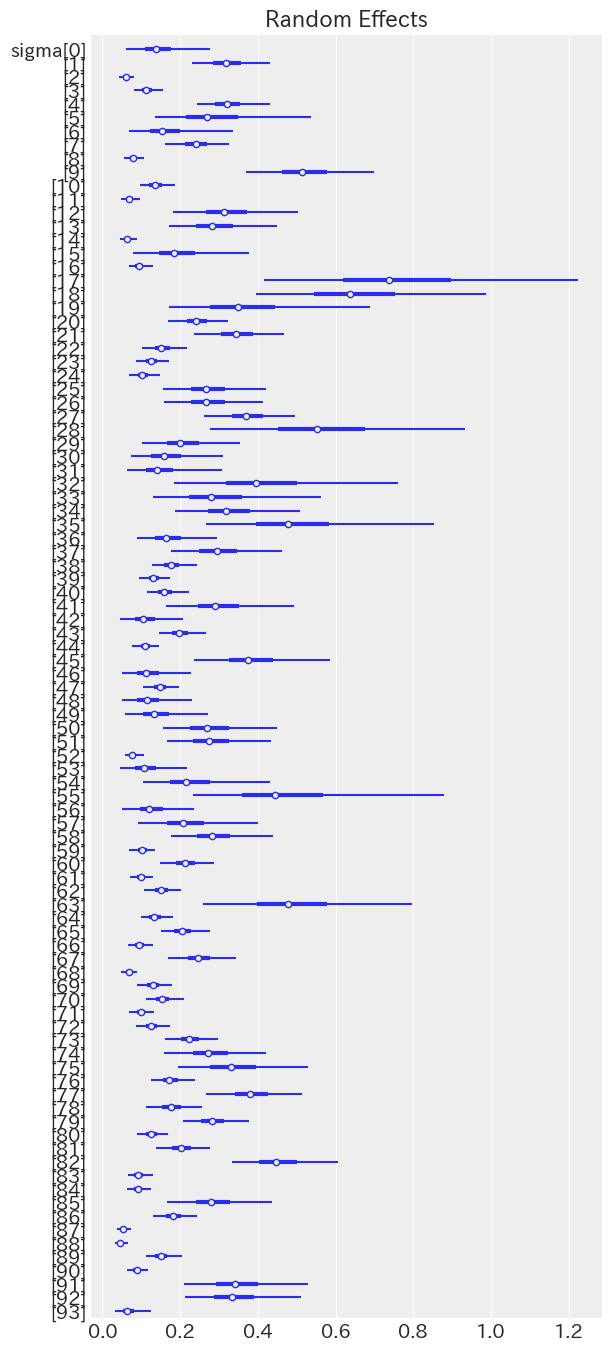

In [8]:
axes = az.plot_forest(
    trace_h,
    kind='forestplot',
    var_names=['sigma'],
    filter_vars='regex',
    combined=True,
    hdi_prob=.95
);
axes[0].set_title('Random Effects');

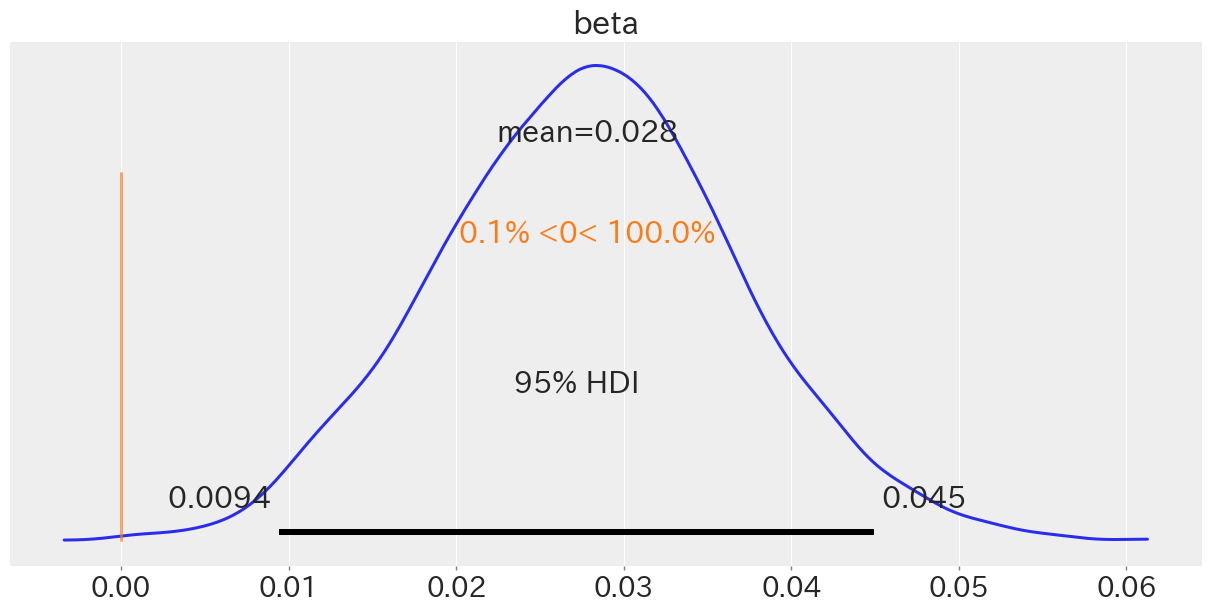

In [10]:
az.plot_posterior(trace_h, var_names=['beta'], ref_val=0, hdi_prob=.95, figsize=(12, 6));

In [12]:
with model_h:
    pm.compute_log_likelihood(trace_h)

Output()

In [13]:
az.waic(trace_h)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 1723 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   471.15    42.32
p_waic       83.64        -

There has been a warning during the calculation. Please check the results.

In [14]:
with model_h:
    pm.sample_posterior_predictive(trace_h, extend_inferencedata=True)

Sampling: [y_obs_observed]


Output()

<Axes: xlabel='y_obs_observed'>

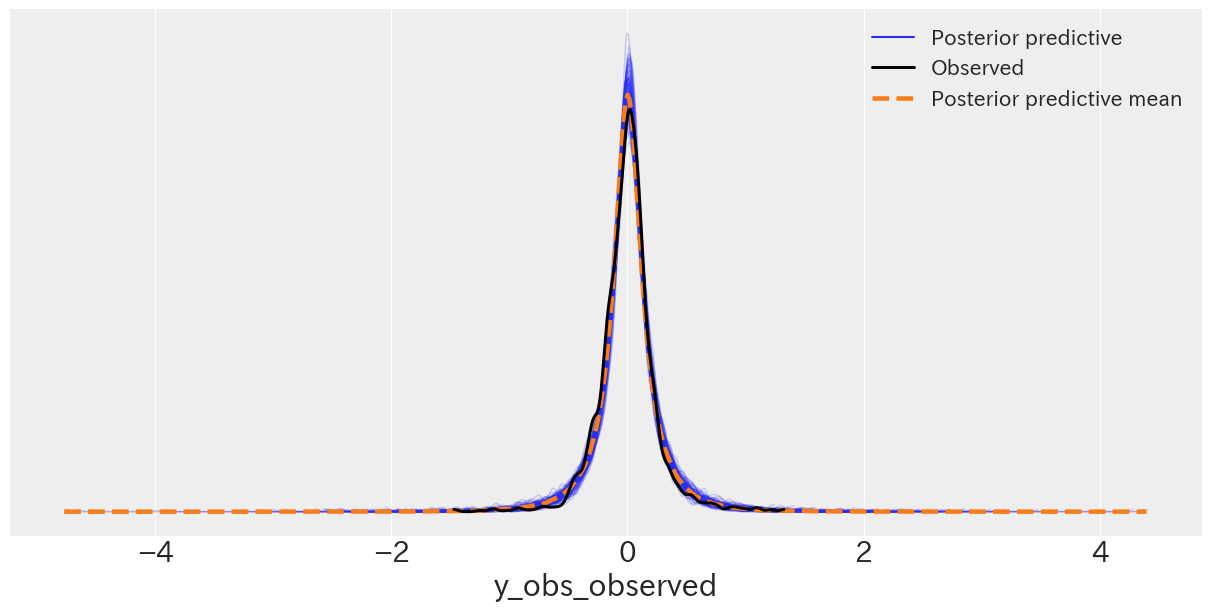

In [15]:
az.plot_ppc(trace_h, num_pp_samples=100, kind='kde', figsize=(12, 6))

## 階層ベイズモデル 不均一分散

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


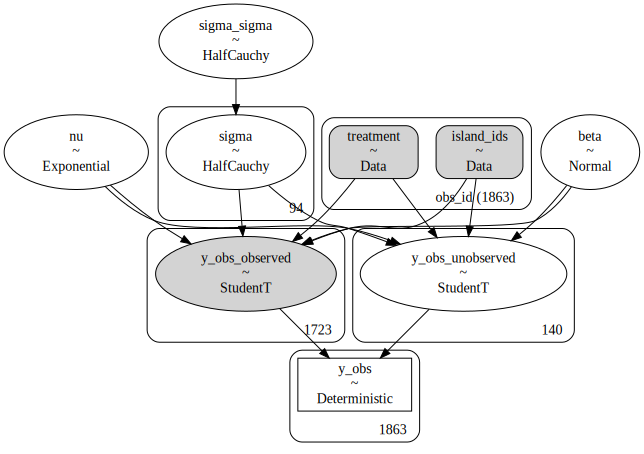

In [3]:
# 0から始まるインデックスを振り直す
island_ids, unique_island_ids = pd.factorize(df['island_ids'])
n_islands = len(unique_island_ids)

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as model_h_hetero:
    # data
    island_ids = pm.Data('island_ids', island_ids, dims='obs_id')
    treatment = pm.Data('treatment', df['after_treatment'], dims='obs_id')

    # priors
    # random effects
    sigma_sigma = pm.HalfCauchy('sigma_sigma', beta=1)
    sigma = pm.HalfCauchy('sigma', beta=sigma_sigma, shape=n_islands)

    # fixed effects
    beta = pm.Normal('beta', mu=0, sigma=0.1)
    nu = pm.Exponential('nu', lam=1/10)

    # expectation
    mu = beta * treatment

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma[island_ids], observed=df['log_pop_star'])

pm.model_to_graphviz(model_h_hetero)

In [4]:
with model_h_hetero:
    trace_h_hetero = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        nuts_sampler='numpyro',
        random_seed=42,
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [5]:
az.summary(trace_h_hetero, var_names=['beta', 'nu', 'sigma_sigma'], hdi_prob=.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta         0.029  0.009     0.011      0.046      0.000    0.000    1996.0   
nu           7.524  1.502     5.008     10.480      0.039    0.027    1448.0   
sigma_sigma  0.175  0.022     0.136      0.221      0.000    0.000    4538.0   

             ess_tail  r_hat  
beta           2796.0    1.0  
nu             2095.0    1.0  
sigma_sigma    3243.0    1.0

In [ ]:
az.summary(trace_h_hetero, var_names=['beta', 'nu', 'sigma_sigma'], hdi_prob=.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta         0.029  0.009     0.012      0.046      0.000    0.000    2083.0   
nu           7.499  1.545     4.853     10.608      0.037    0.026    1765.0   
sigma_sigma  0.175  0.023     0.131      0.218      0.000    0.000    4572.0   

             ess_tail  r_hat  
beta           3112.0    1.0  
nu             2300.0    1.0  
sigma_sigma    2808.0    1.0

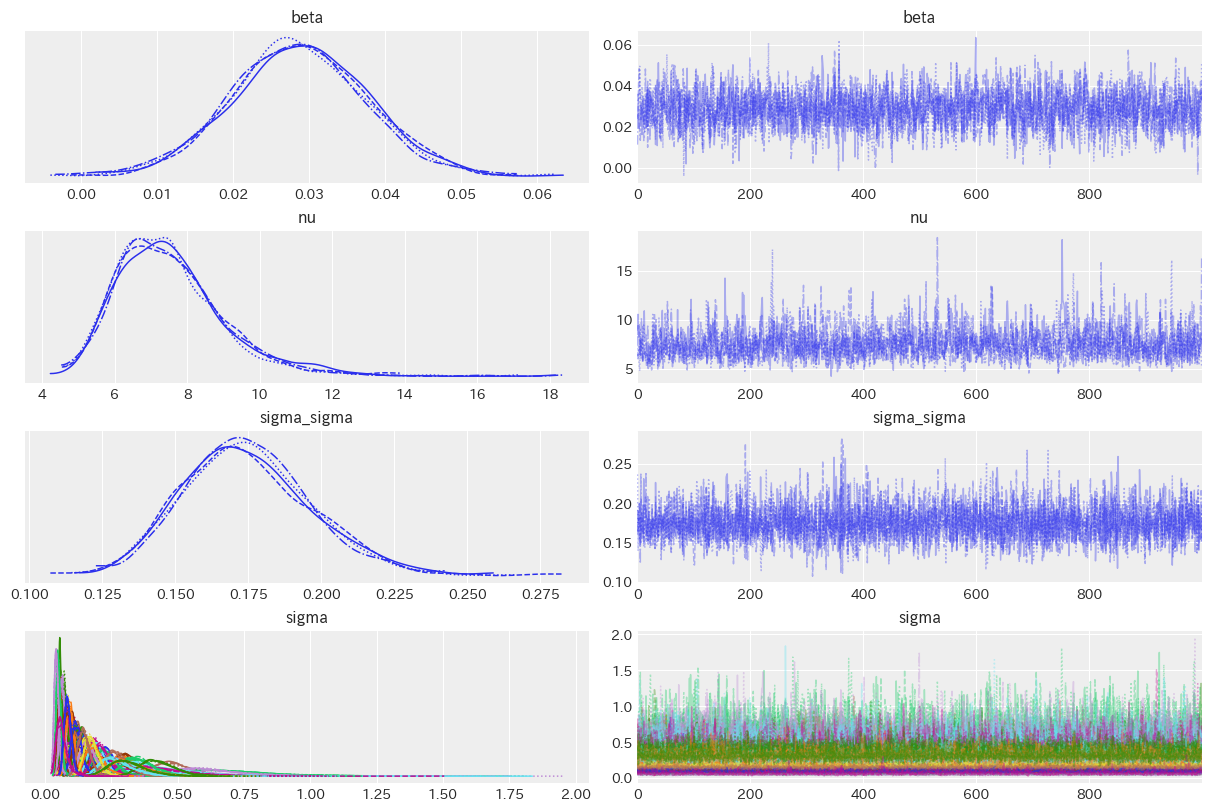

In [6]:
az.plot_trace(trace_h_hetero, var_names=['beta', 'nu', 'sigma_sigma', 'sigma']);

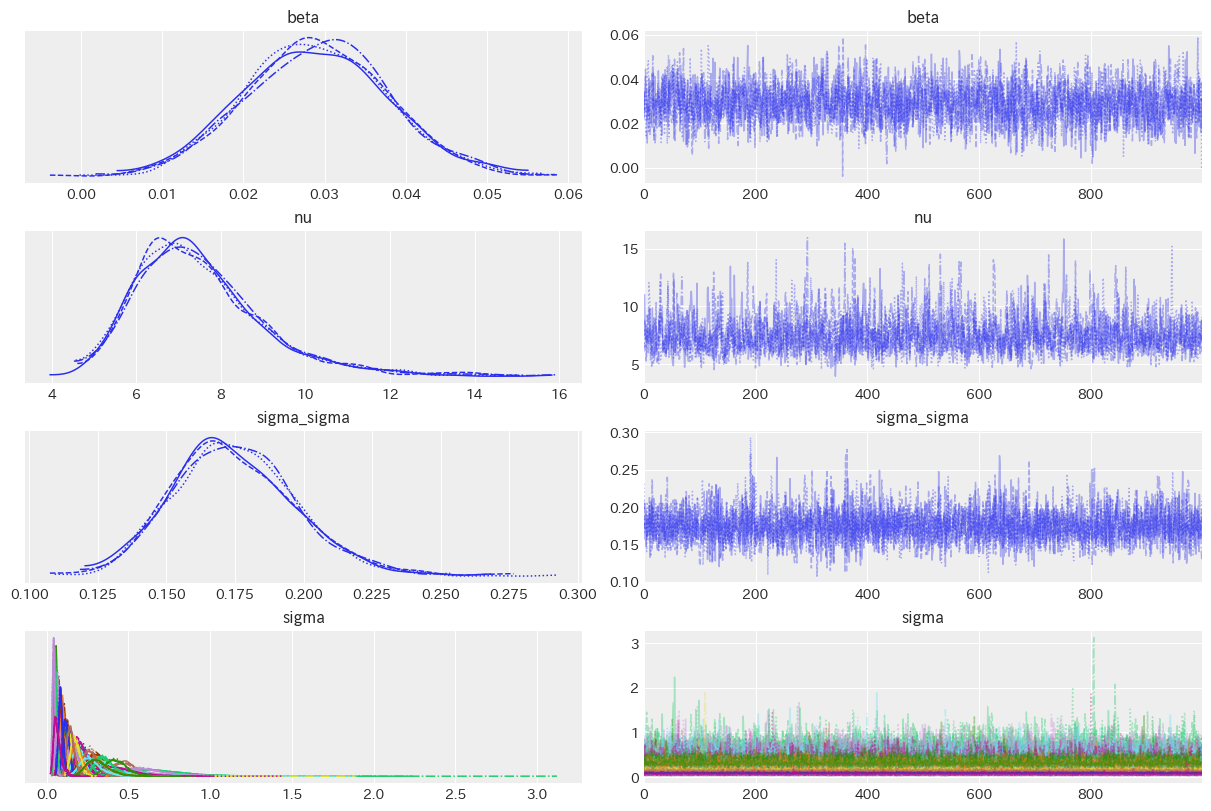

In [ ]:
az.plot_trace(trace_h_hetero, var_names=['beta', 'nu', 'sigma_sigma', 'sigma']);

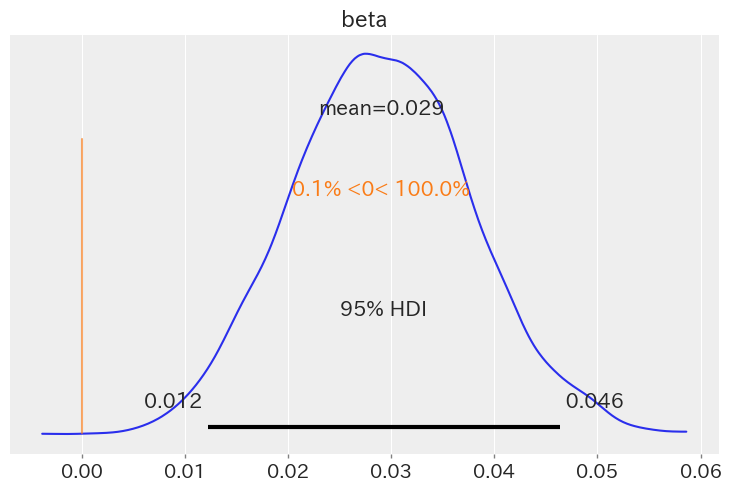

In [9]:
az.plot_posterior(trace_h_hetero, var_names=['beta'], ref_val=0, hdi_prob=.95);

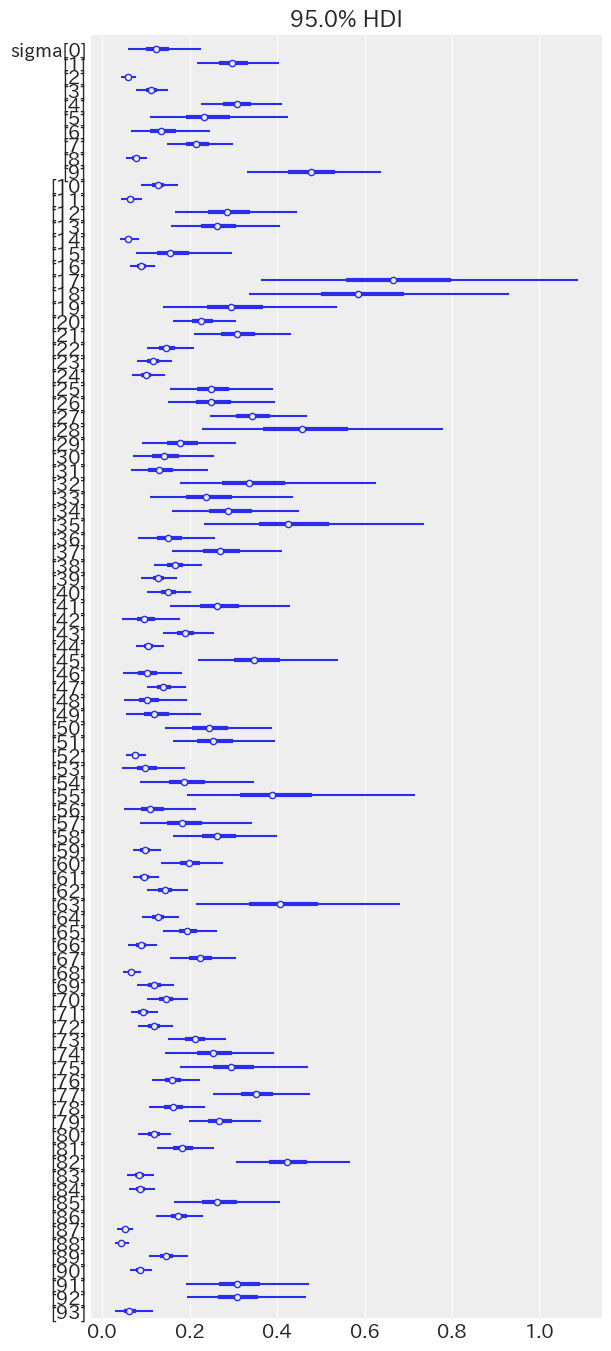

In [10]:
az.plot_forest(
    trace_h_hetero,
    kind='forestplot',
    var_names=['sigma'],
    combined=True,
    hdi_prob=.95
);

## 不均一分散とランダム係数

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


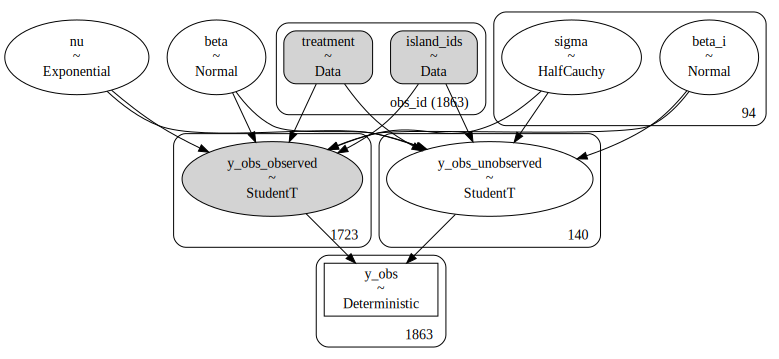

In [23]:
# 0から始まるインデックスを振り直す
island_ids, unique_island_ids = pd.factorize(df['island_ids'])
n_islands = len(unique_island_ids)

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as model_3:
    # data
    island_ids = pm.Data('island_ids', island_ids, dims='obs_id')
    treatment = pm.Data('treatment', df['after_treatment'], dims='obs_id')

    # priors
    # random effects
    beta = pm.Normal('beta', mu=0, sigma=1, shape=n_islands)
    sigma = pm.HalfCauchy('sigma', beta=1, shape=n_islands)
    # fixed effects
    nu = pm.Exponential('nu', lam=1/10)

    # expectation
    mu = beta[island_ids] * treatment

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma[island_ids], observed=df['log_pop_star'])

pm.model_to_graphviz(model_3)

In [30]:
with model_3:
    trace_3 = pm.sample(
        draws=3000,
        tune=1000,
        chains=4,
        nuts_sampler='numpyro',
        random_seed=42,
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [31]:
az.summary(trace_3, var_names=['beta', 'nu', 'beta_i', 'sigma'], hdi_prob=.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta       0.001  0.145    -0.302      0.271      0.006    0.004     556.0   
nu         6.565  1.240     4.397      8.964      0.018    0.013    5196.0   
beta_i[0]  0.097  0.161    -0.218      0.414      0.006    0.004     678.0   
beta_i[1] -0.163  0.228    -0.589      0.307      0.006    0.004    1394.0   
beta_i[2] -0.003  1.010    -1.912      2.009      0.007    0.010   19385.0   
...          ...    ...       ...        ...        ...      ...       ...   
sigma[89]  0.150  0.024     0.107      0.200      0.000    0.000   16715.0   
sigma[90]  0.088  0.014     0.063      0.117      0.000    0.000   18489.0   
sigma[91]  0.283  0.082     0.145      0.449      0.001    0.001   14060.0   
sigma[92]  0.155  0.043     0.084      0.236      0.000    0.000   14425.0   
sigma[93]  0.073  0.032     0.027      0.133      0.001    0.000    3585.0   

           ess_tail  r_hat  
beta          856.0   1.01  
nu           5477.0   1.00  
beta_i[0]    1398.0   1.01  
beta_i[1]    3738.0   1.00  
beta_i[2]    9259.0   1.00  
...             ...    ...  
sigma[89]    8257.0   1.00  
sigma[90]    7673.0   1.00  
sigma[91]    8230.0   1.00  
sigma[92]    7572.0   1.00  
sigma[93]    4325.0   1.00  

[190 rows x 9 columns]

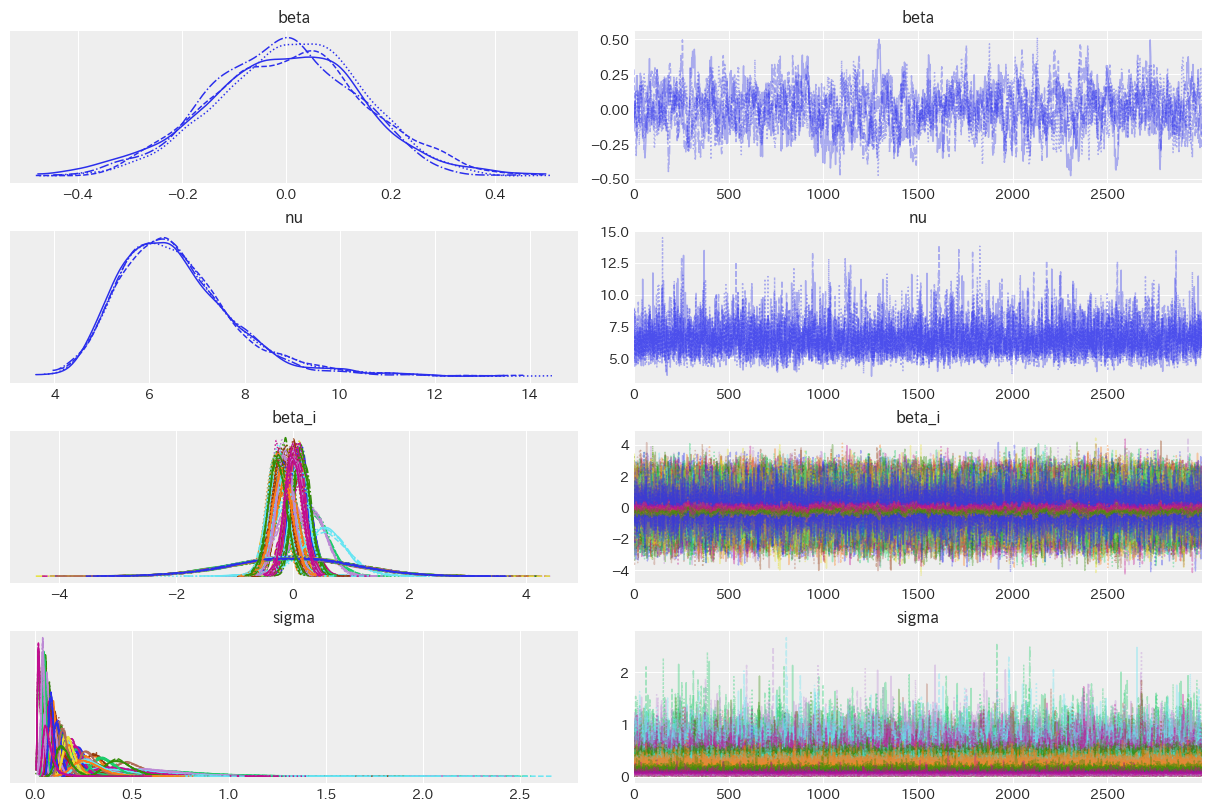

In [32]:
az.plot_trace(trace_3, var_names=['beta', 'nu', 'beta_i', 'sigma']);

In [125]:
beta_i_df = az.summary(trace_3, var_names=['beta_i'], hdi_prob=.95, kind='stats')
beta_i_df['island_ids'] = unique_island_ids
beta_i_df_filtered = beta_i_df[beta_i_df['sd'] < 0.8]

In [164]:
beta_i_df_filtered.describe()

mean         sd   hdi_2.5%  hdi_97.5%  island_ids
count  49.000000  49.000000  49.000000  49.000000   49.000000
mean   -0.008551   0.175857  -0.350939   0.341163  141.387755
std     0.169728   0.055065   0.153336   0.240478   44.877062
min    -0.285000   0.146000  -0.626000   0.013000   67.000000
25%    -0.141000   0.149000  -0.498000   0.177000  108.000000
50%     0.014000   0.155000  -0.296000   0.323000  139.000000
75%     0.115000   0.174000  -0.218000   0.426000  173.000000
max     0.502000   0.457000  -0.124000   1.402000  226.000000

In [141]:
class BetaIProtter:
    def __init__(self, beta_i_df):
        self.beta_i_df = beta_i_df

    def plot(self):
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.scatterplot(x='island_ids', y='mean', data=self.beta_i_df, ax=ax)
        ax.errorbar(
            x=self.beta_i_df['island_ids'],
            y=self.beta_i_df['mean'],
            yerr=(
                self.beta_i_df['mean'] - self.beta_i_df['hdi_2.5%'],
                self.beta_i_df['hdi_97.5%'] - self.beta_i_df['mean']
            ),
            fmt='o',
            color='black',
            capsize=5,
        )
        ax.axhline(y=0, color='black', linestyle='--')
        ax.set_title('Random Effects by Island')

    def find_significant(self):
        return self.beta_i_df[(self.beta_i_df['hdi_2.5%'] > 0)]

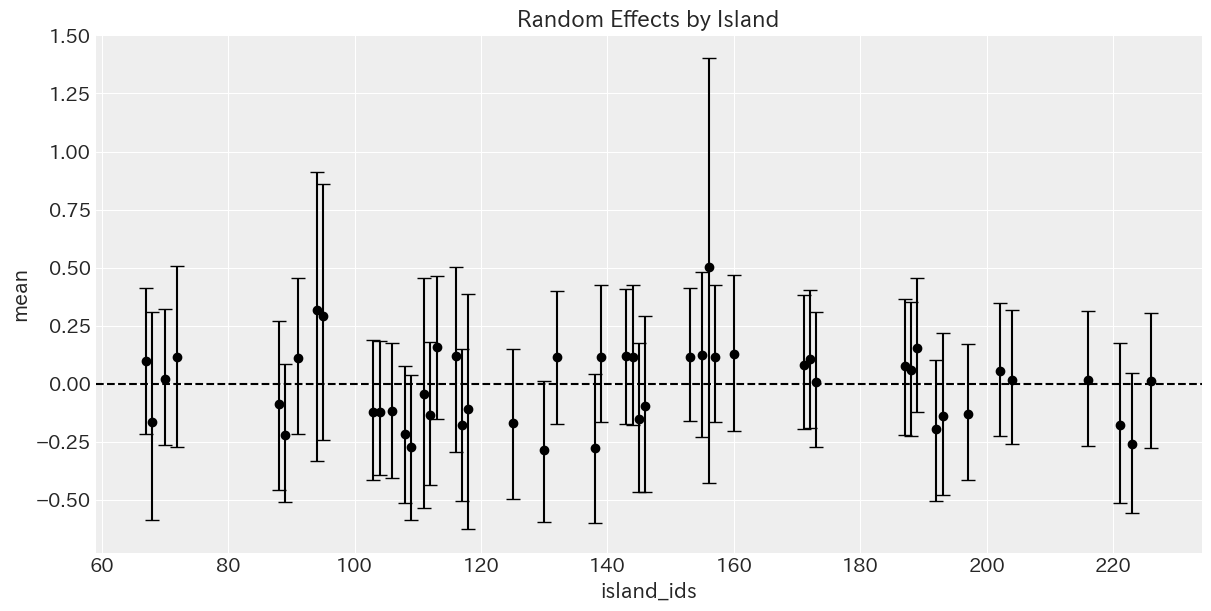

In [142]:
beta_i_plotter = BetaIProtter(beta_i_df_filtered)
beta_i_plotter.plot()

In [169]:
beta_i_df[beta_i_df['hdi_97.5%'] <= 0.1]

mean     sd  hdi_2.5%  hdi_97.5%  island_ids
beta_i[13] -0.221  0.150    -0.511      0.084          89
beta_i[25] -0.217  0.149    -0.512      0.076         108
beta_i[26] -0.273  0.162    -0.588      0.037         109
beta_i[41] -0.285  0.155    -0.594      0.013         130
beta_i[45] -0.279  0.163    -0.598      0.040         138
beta_i[92] -0.259  0.153    -0.558      0.044         223

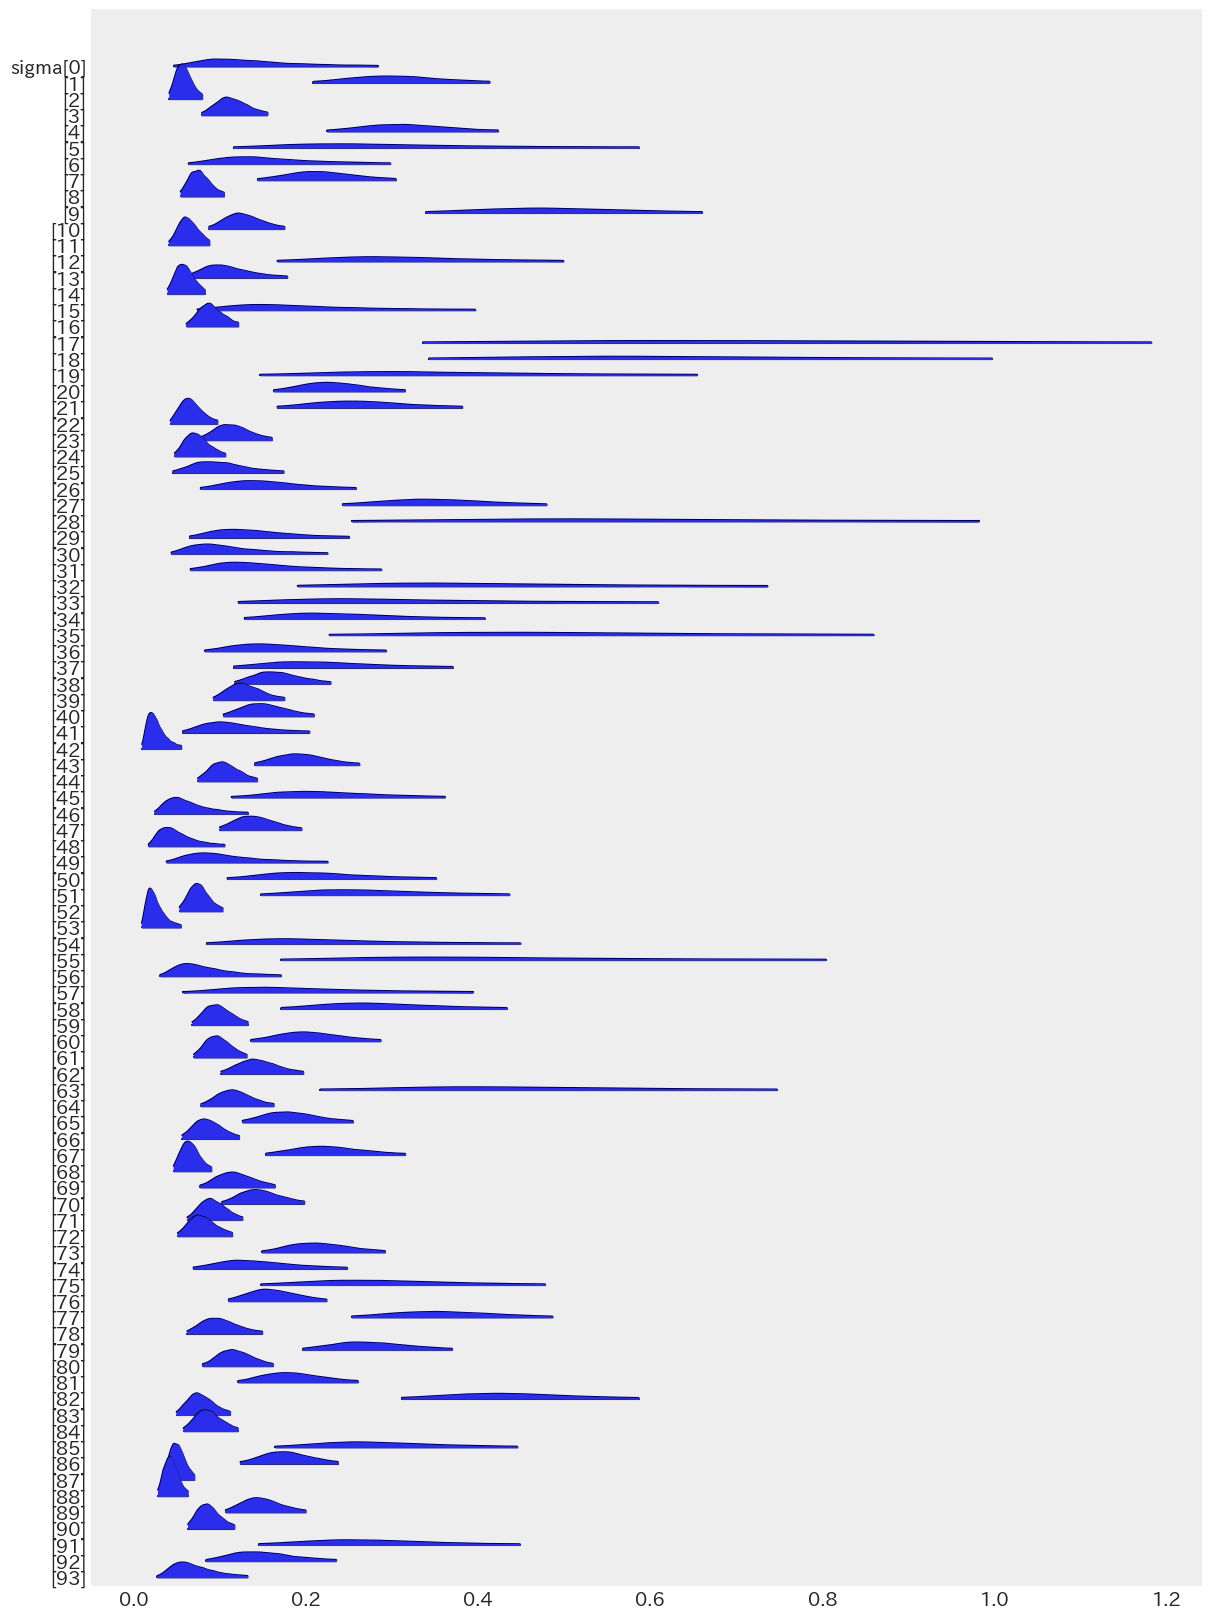

In [53]:
az.plot_forest(
    trace_3,
    kind='ridgeplot',
    var_names=['sigma'],
    combined=True,
    hdi_prob=.95
);

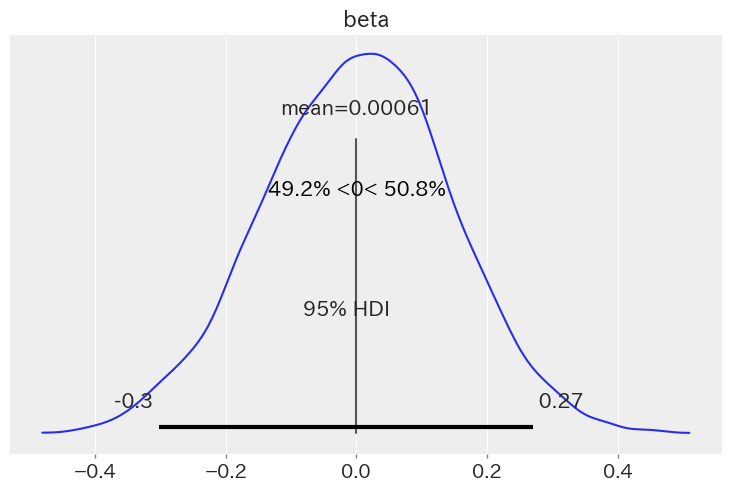

In [40]:
az.plot_posterior(trace_3, var_names=['beta'], ref_val=0, ref_val_color='black', hdi_prob=.95);

In [36]:
with model_3:
    pm.compute_log_likelihood(trace_3)

Output()

In [37]:
az.waic(trace_3)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 12000 posterior samples and 1723 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   593.51    44.64
p_waic      127.31        -

There has been a warning during the calculation. Please check the results.

In [38]:
with model_3:
    pm.sample_posterior_predictive(trace_3, extend_inferencedata=True)

Sampling: [y_obs_observed]


Output()

<Axes: xlabel='y_obs_observed'>

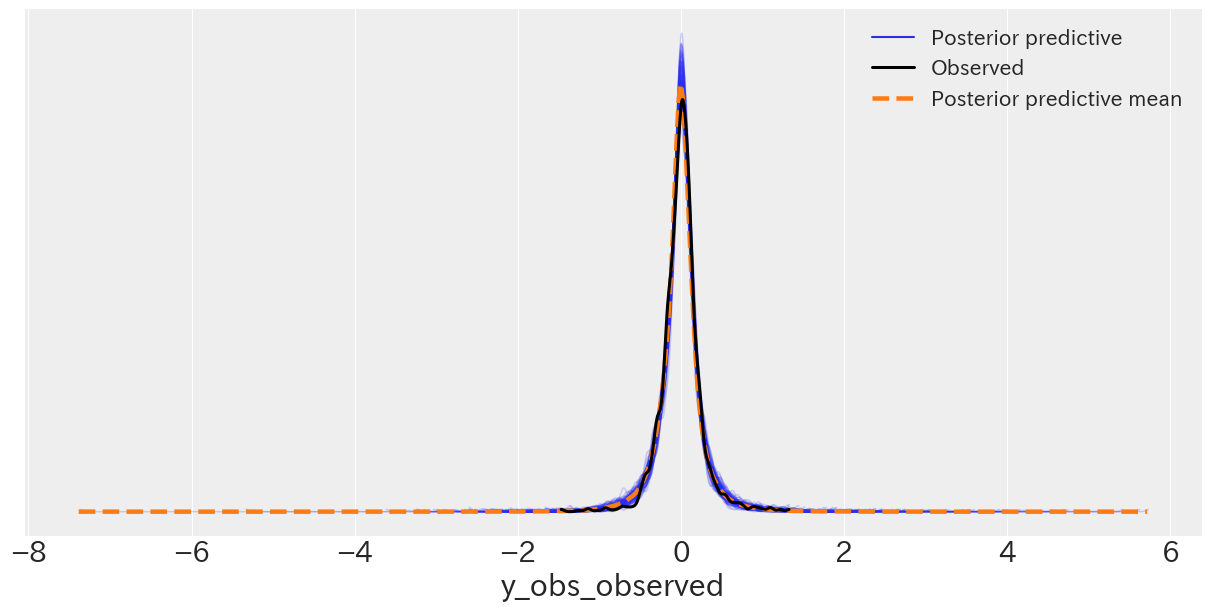

In [39]:
az.plot_ppc(trace_3, num_pp_samples=100, kind='kde', figsize=(12, 6))

## 階層ベイズモデル

### 不均一分散とランダム効果

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


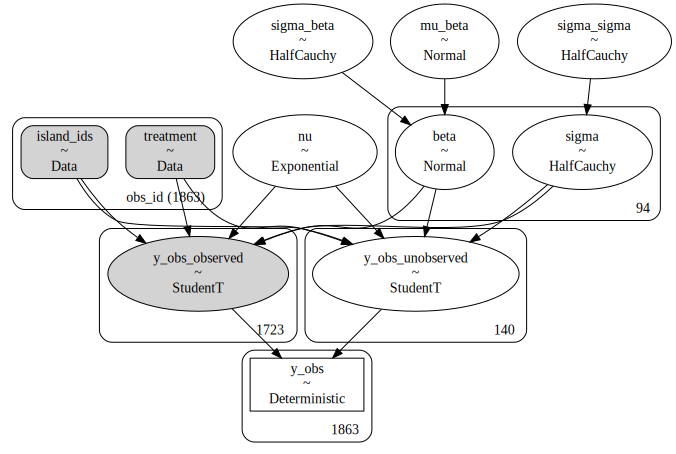

In [ ]:
# 0から始まるインデックスを振り直す
island_ids, unique_island_ids = pd.factorize(df['island_ids'])
n_islands = len(unique_island_ids)

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as model_h:
    # data
    island_ids = pm.Data('island_ids', island_ids, dims='obs_id')
    treatment = pm.Data('treatment', df['after_treatment'], dims='obs_id')

    # priors
    # random effects
    mu_beta = pm.Normal('mu_beta', mu=0, sigma=1)
    sigma_beta = pm.HalfCauchy('sigma_beta', beta=1)
    beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=n_islands)

    # 不均一分散
    sigma_sigma = pm.HalfCauchy('sigma_sigma', beta=1)
    sigma = pm.HalfCauchy('sigma', beta=sigma_sigma, shape=n_islands)

    # fixed effects
    nu = pm.Exponential('nu', lam=1/10)

    # expectation
    mu = beta[island_ids] * treatment

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma[island_ids], observed=df['log_pop_star'])

pm.model_to_graphviz(model_h)

In [9]:
with model_h:
    trace_h = pm.sample(
        draws=1500,
        tune=1500,
        chains=4,
        nuts_sampler='numpyro',
        random_seed=42,
    )

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [10]:
az.summary(trace_h, var_names=['mu_beta', 'sigma_beta', 'beta'], hdi_prob=.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mu_beta    -0.019  0.022    -0.064      0.024      0.000    0.000    4843.0   
sigma_beta  0.139  0.018     0.106      0.174      0.000    0.000    1984.0   
beta[0]     0.083  0.052    -0.028      0.181      0.001    0.000    7411.0   
beta[1]    -0.080  0.108    -0.290      0.137      0.001    0.001    9433.0   
beta[2]    -0.019  0.145    -0.297      0.282      0.001    0.002   12175.0   
...           ...    ...       ...        ...        ...      ...       ...   
beta[89]   -0.022  0.137    -0.294      0.243      0.001    0.002   11009.0   
beta[90]   -0.019  0.142    -0.299      0.255      0.001    0.002   13625.0   
beta[91]   -0.138  0.071    -0.283     -0.002      0.001    0.001    8006.0   
beta[92]   -0.229  0.045    -0.316     -0.139      0.000    0.000   10327.0   
beta[93]    0.013  0.029    -0.043      0.075      0.000    0.000    6053.0   

            ess_tail  r_hat  
mu_beta       4531.0    1.0  
sigma_beta    3651.0    1.0  
beta[0]       3215.0    1.0  
beta[1]       4860.0    1.0  
beta[2]       4039.0    1.0  
...              ...    ...  
beta[89]      4376.0    1.0  
beta[90]      4389.0    1.0  
beta[91]      4244.0    1.0  
beta[92]      3793.0    1.0  
beta[93]      3505.0    1.0  

[96 rows x 9 columns]

In [11]:
az.summary(trace_h, var_names=['nu', 'sigma_sigma', 'sigma'], hdi_prob=.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
nu           4.877  0.689     3.691      6.313      0.012    0.008    3328.0   
sigma_sigma  0.140  0.018     0.106      0.175      0.000    0.000   10081.0   
sigma[0]     0.114  0.049     0.039      0.209      0.001    0.001    1970.0   
sigma[1]     0.286  0.052     0.200      0.396      0.001    0.000    8201.0   
sigma[2]     0.056  0.010     0.040      0.077      0.000    0.000   12183.0   
...            ...    ...       ...        ...        ...      ...       ...   
sigma[89]    0.144  0.024     0.101      0.192      0.000    0.000   13298.0   
sigma[90]    0.085  0.014     0.060      0.112      0.000    0.000   11348.0   
sigma[91]    0.235  0.069     0.114      0.373      0.001    0.001    9061.0   
sigma[92]    0.138  0.036     0.076      0.210      0.000    0.000   10955.0   
sigma[93]    0.067  0.027     0.025      0.117      0.001    0.000    2403.0   

             ess_tail  r_hat  
nu             4575.0    1.0  
sigma_sigma    4283.0    1.0  
sigma[0]       2528.0    1.0  
sigma[1]       4596.0    1.0  
sigma[2]       4000.0    1.0  
...               ...    ...  
sigma[89]      4143.0    1.0  
sigma[90]      4308.0    1.0  
sigma[91]      3739.0    1.0  
sigma[92]      4610.0    1.0  
sigma[93]      2826.0    1.0  

[96 rows x 9 columns]

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'mu_beta'}>,
        <Axes: title={'center': 'mu_beta'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'y_obs_unobserved'}>,
        <Axes: title={'center': 'y_obs_unobserved'}>],
       [<Axes: title={'center': 'sigma_beta'}>,
        <Axes: title={'center': 'sigma_beta'}>],
       [<Axes: title={'center': 'sigma_sigma'}>,
        <Axes: title={'center': 'sigma_sigma'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>],
       [<Axes: title={'center': 'y_obs'}>,
        <Axes: title={'center': 'y_obs'}>]], dtype=object)

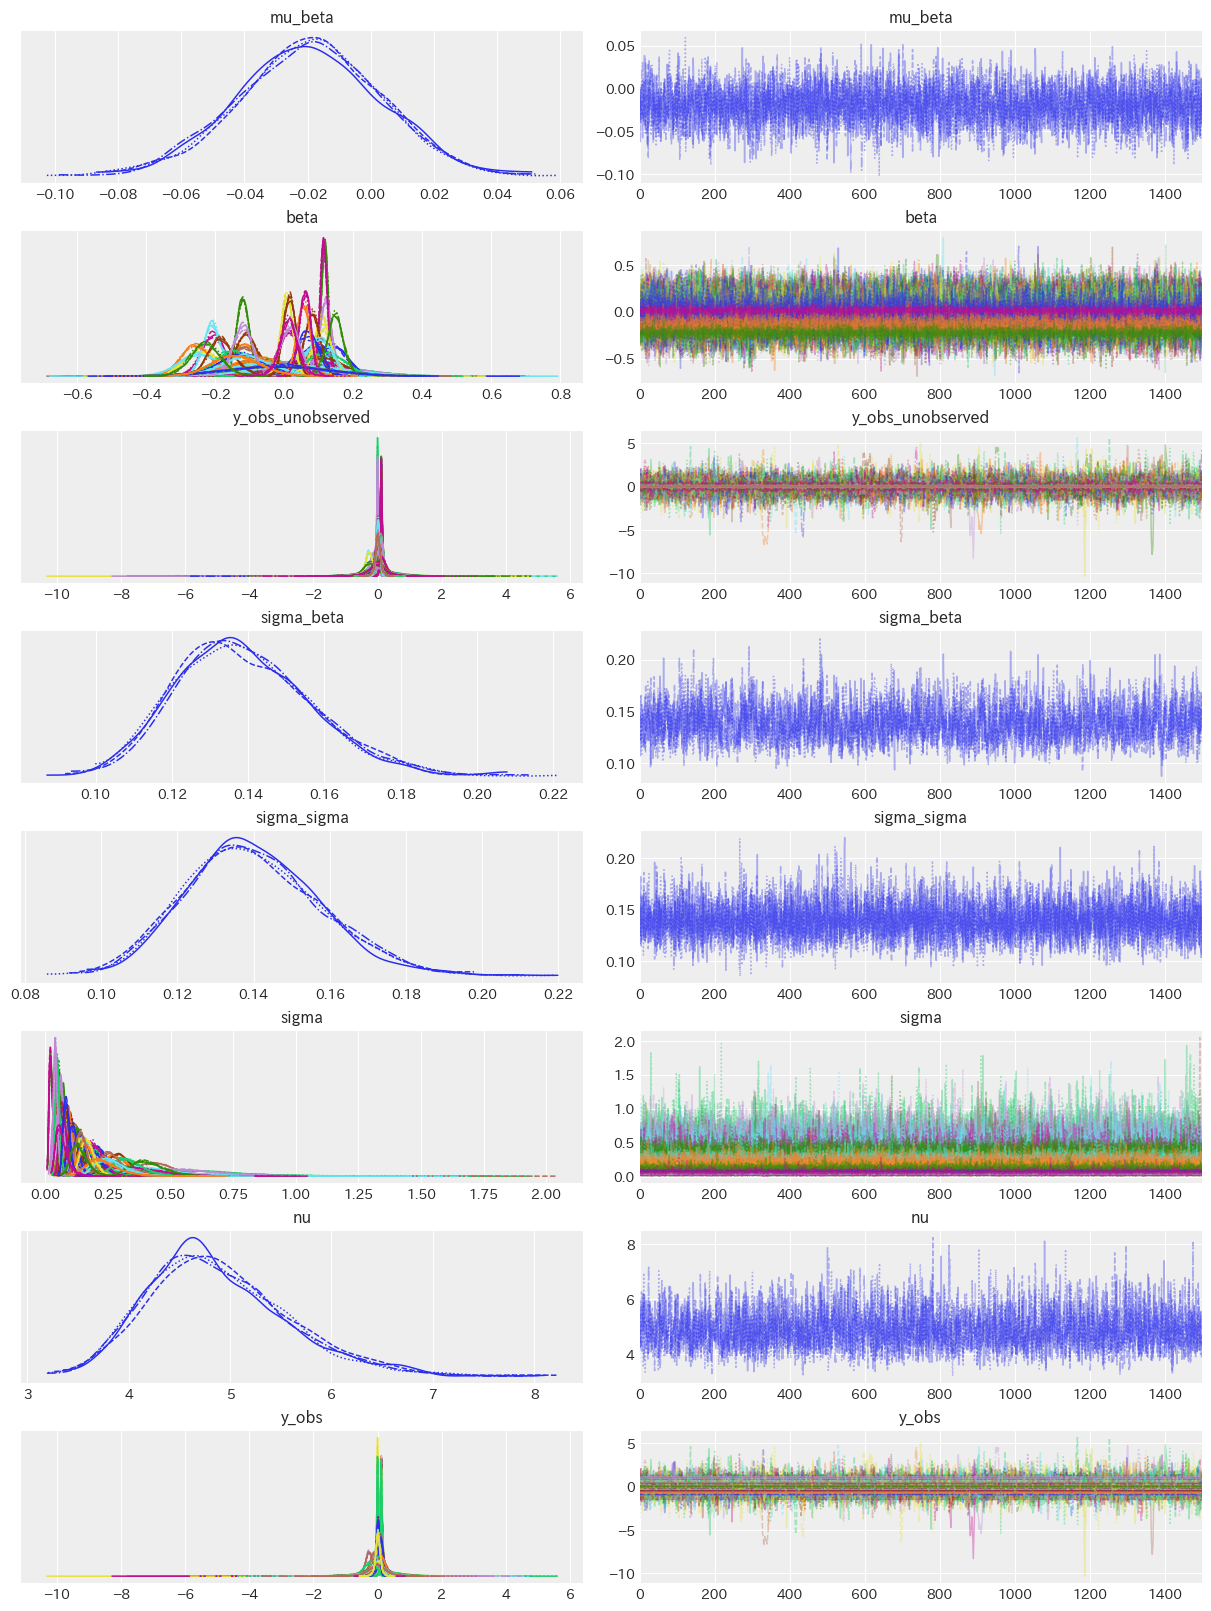

In [12]:
az.plot_trace(trace_h);

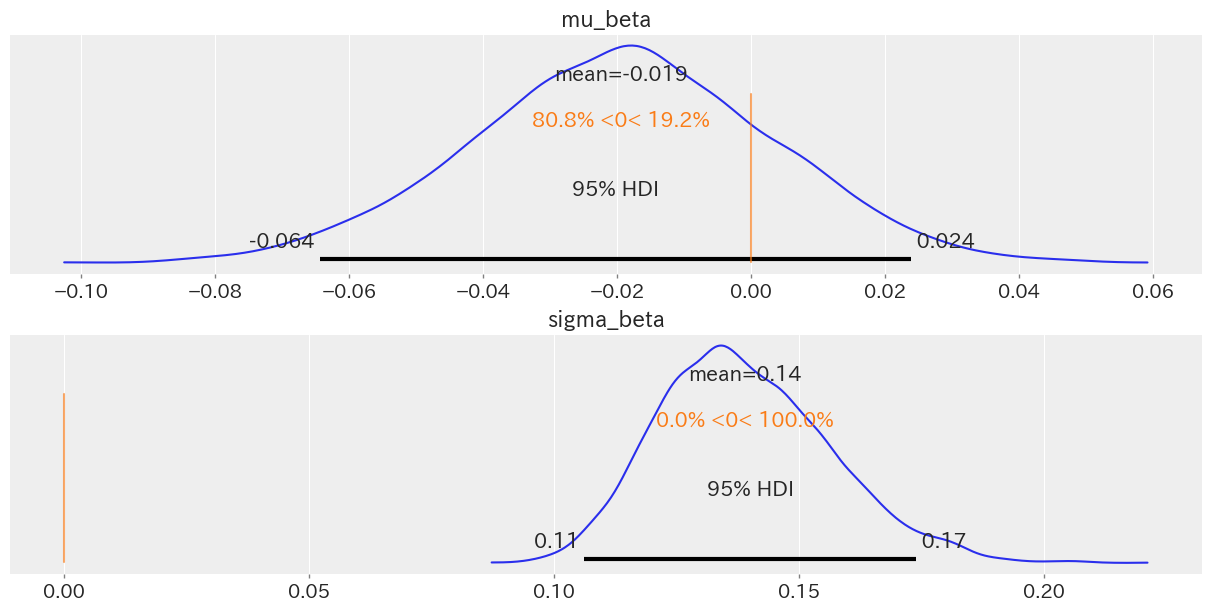

In [20]:
_, ax = plt.subplots(2, 1, figsize=(12, 6))
az.plot_posterior(trace_h, var_names=['mu_beta'], ref_val=0, hdi_prob=.95, ax=ax[0])
az.plot_posterior(trace_h, var_names=['sigma_beta'], ref_val=0, hdi_prob=.95, ax=ax[1]);
plt.show()

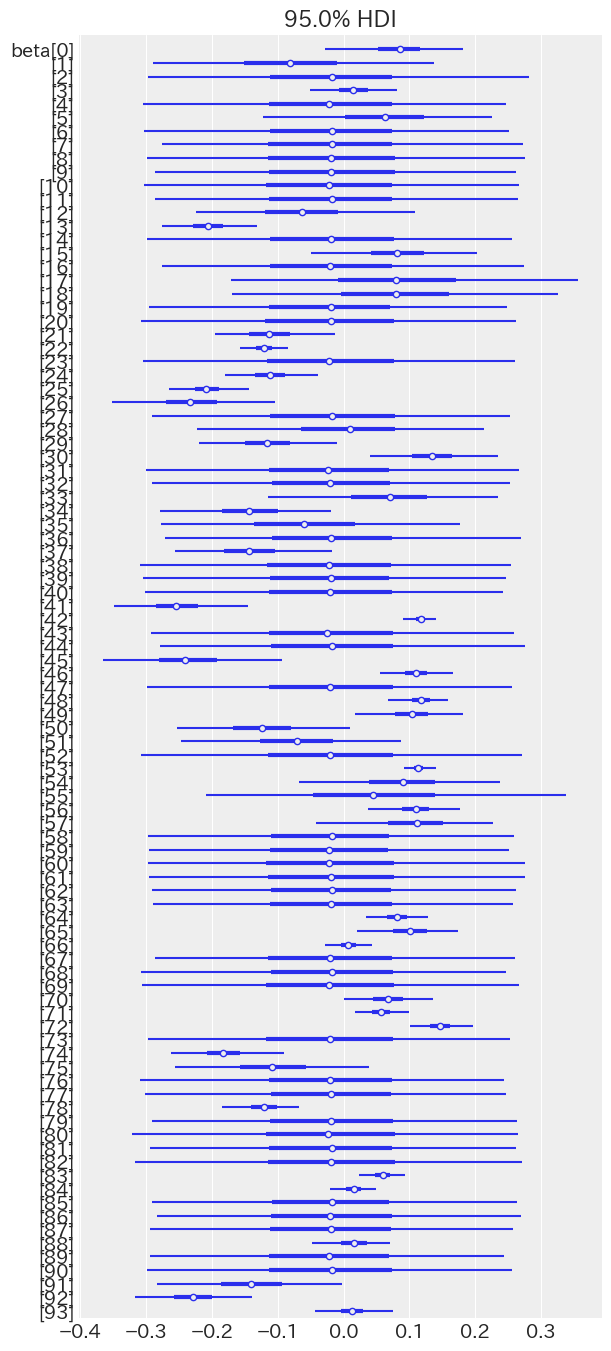

In [18]:
az.plot_forest(
    trace_h,
    kind='forestplot',
    var_names=['beta'],
    combined=True,
    hdi_prob=.95
);

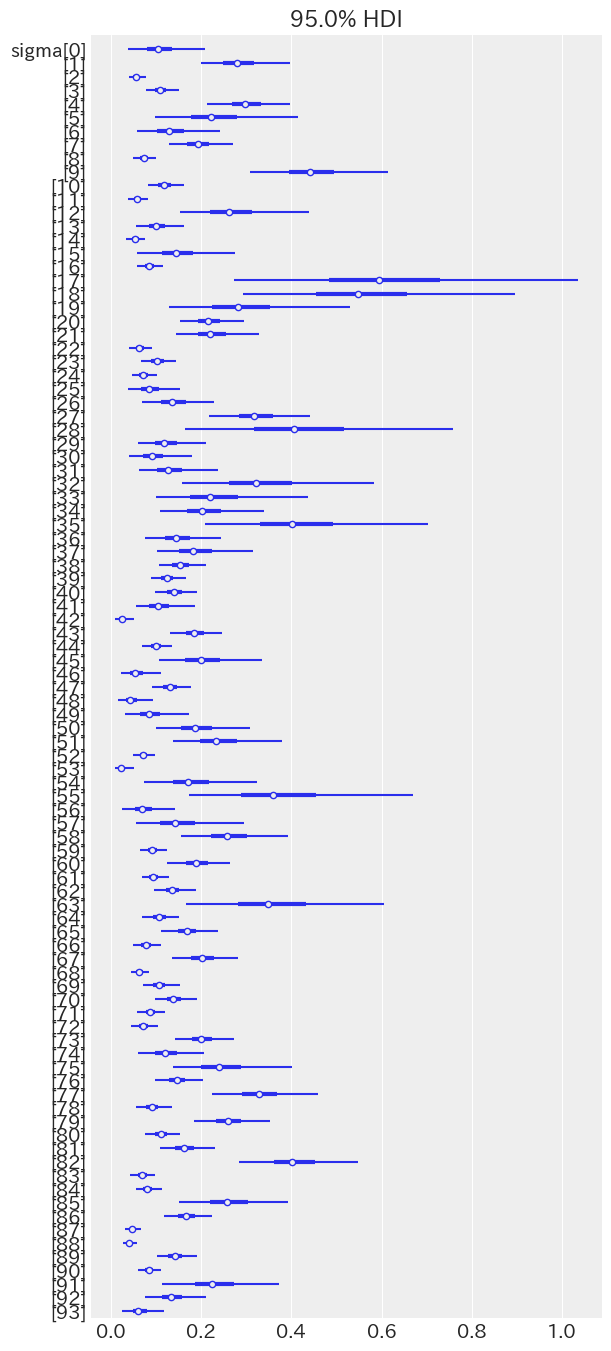

In [13]:
az.plot_forest(
    trace_h,
    kind='forestplot',
    var_names=['sigma'],
    combined=True,
    hdi_prob=.95
);

In [18]:
az.waic(trace_h)

Computed from 3000 posterior samples and 1723 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -946.45    42.06
p_waic       49.53        -

## サンプリングの保存

In [22]:
# az.to_netcdf(trace, './mcmc_sample/twfe.nc')
az.to_netcdf(trace_h, './mcmc_sample/twfe_h.nc')

'./mcmc_sample/twfe_h.nc'

## サンプリングのインポート

In [75]:
# trace = az.from_netcdf('./mcmc_sample/twfe.nc')
# trace_h = az.from_netcdf('./sample/twfe_h.nc')
# trace_twfe_student_t = az.from_netcdf('./sample/traces_twfe_student_t_log.nc')
# trace_twfe_h_student_t = az.from_netcdf('./sample/traces_twfe_h_student_t_log.nc')